In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import nltk as nltk
import re
import cred
import seaborn as sns
from textblob import TextBlob
import string
from wordcloud import WordCloud 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aperniah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
def connect_db(user,password,host,port,database):
    connection = psycopg2.connect(user = user,
                                  password = password,
                                  host = host,
                                  port = port,
                                  database = database)
            
    return connection

In [15]:
def cursor_init(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")  
    return cursor

In [16]:
def select_tuits(topic,cursor):
    #json.dumps(x)
    script = f"Select tweet,topic,city_searched,country_searched FROM data_tweets where topic = '{topic}'"
    cursor.execute(script)
    return cursor

In [17]:
def transform_data(cursor):
    tweets = []
    columns = cursor.description
    for t in cursor.fetchall():
        tweet = t[0]
        tweets.append([tweet['id'], 
                    tweet['full_text'],
                    tweet['retweet_count'],
                    tweet['favorite_count'],
                    tweet['created_at'],
                    tweet['user']['screen_name'], 
                    [i['screen_name'] for i in tweet['entities']['user_mentions']],
                    tweet['user']['description'],
                    tweet['user']['verified'],
                    tweet['user']['location'],
                    tweet['user']['statuses_count'], 
                    tweet['user']['followers_count'], 
                    tweet['user']['friends_count'], 
                    tweet['user']['favourites_count'], 
                    tweet['user']['created_at'], 
                    tweet['user']['profile_image_url'],
                    tweet['user']['created_at'],
                    t[1],
                    t[2],
                    t[3]])

    return tweets

In [18]:
topico_a='trump'
topico_b='biden'
topico_a2='donald trump'
topico_b2='joe biden'
columns = ['id' , 'full_text', 'retweet_count', 'favorite_count', 'created_at', 'user_screen_name' , 'user_mentions', 'user_description', 'user_verified', 'user_location', 'user_statuses_count' , 'user_followers_count' , 'user_friends_count' , 'user_favourites_count' , 'user_created_at' , 'user_profile_image_url', 'user_created_at', 'topic','city_searched','country_searched']

In [19]:
connection = connect_db(cred.database_user,cred.database_pass,"192.168.0.22",'5432','data_tweets')
cursor_a = cursor_init(connection)
cursor_b = cursor_init(connection)

You are connected to -  ('PostgreSQL 12.4 (Ubuntu 12.4-1.pgdg20.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.3.0-10ubuntu2) 9.3.0, 64-bit',) 

You are connected to -  ('PostgreSQL 12.4 (Ubuntu 12.4-1.pgdg20.04+1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.3.0-10ubuntu2) 9.3.0, 64-bit',) 



In [20]:
d_a = select_tuits(topico_a, cursor_a)

In [21]:
d_b = select_tuits(topico_b, cursor_b)

In [22]:
data_a = transform_data(d_a)


In [23]:
data_b = transform_data(d_b)


In [24]:
df_a = pd.DataFrame(data_a,columns=columns)
df_b = pd.DataFrame(data_b,columns=columns)

In [25]:
df_a.count()[1],df_b.count()[1]

(7058, 1031)

In [26]:
def transform2(text):
    stopWords = set(stopwords.words('spanish'))
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # Remover menciones 
    text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
    text = re.sub(r'#', ' ', text) # Remover # en el tweet
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
    text = text.lower().replace('jaja','')
    text = text.lower().replace(' ja ','')
    text = text.lower().replace(' va ','')
    text = text.lower().replace(' si ','')
    text = text.lower().replace(' ser ','')
    #text = re.sub(r'',' ',text)
    words = text.lower().split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    no_garbage = [w for w in stripped if not w in stopWords]
    return (' '.join(no_garbage))

In [27]:
def transform(text):
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # Remover menciones 
    text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
    text = re.sub(r'#', ' ', text) # Remover # en el tweet
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links
    text = text.lower().replace('jaja','')
    #text = re.sub(r'',' ',text)
    words = text.lower().split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    return (' '.join(stripped))

In [28]:
df_a['tuit_text_transform'] = df_a ['full_text'].apply(transform)
df_b['tuit_text_transform'] = df_b ['full_text'].apply(transform)
df_a['tuit_text_transform2'] = df_a ['full_text'].apply(transform2)
df_b['tuit_text_transform2'] = df_b ['full_text'].apply(transform2)

In [29]:
df_b.head()

,id,full_text,retweet_count,favorite_count,created_at,user_screen_name,user_mentions,user_description,user_verified,user_location,...,user_friends_count,user_favourites_count,user_created_at,user_profile_image_url,user_created_at,topic,city_searched,country_searched,tuit_text_transform,tuit_text_transform2
0,1312819283467141120,Una piba de Estados Unidos conociendo los quil...,0,1,Sun Oct 04 18:18:02 +0000 2020,AzulGasparri,[],24 años| Periodista de deportes| Presidente @A...,False,Buenos Aires,...,170,18687,Thu Jan 30 07:18:24 +0000 2020,http://pbs.twimg.com/profile_images/1288691711...,Thu Jan 30 07:18:24 +0000 2020,biden,Buenos Aires,Argentina,una piba de estados unidos conociendo los quil...,piba unidos conociendo quilombos acáte da mied...
1,1312504109275078656,"Otra excelente edición de este podcast, que ay...",2,12,Sat Oct 03 21:25:39 +0000 2020,patricioviolini,[],Diplomático🇦🇷 | MA in Global Policy @SAISHopki...,False,"Buenos Aires, Argentina",...,3733,1583,Mon Jul 19 18:03:56 +0000 2010,http://pbs.twimg.com/profile_images/1292653291...,Mon Jul 19 18:03:56 +0000 2010,biden,Buenos Aires,Argentina,otra excelente edición de este podcast que ayu...,excelente edición podcast ayuda llenar gap inf...
2,1312501945337180160,Ya vi a @HamillHimself diciendo que no confíen...,0,0,Sat Oct 03 21:17:03 +0000 2020,BarbaraKenobi,[HamillHimself],Cualquiera cosa. XXIV,False,BAires,...,487,32289,Sat Oct 11 13:12:33 +0000 2008,http://pbs.twimg.com/profile_images/1261508051...,Sat Oct 11 13:12:33 +0000 2008,biden,Buenos Aires,Argentina,ya vi a diciendo que no confíen en un político...,vi diciendo confíen político quiere perros dig...
3,1311783801022971904,"Repito, hasta ahora NO he visto ningún argumen...",0,0,Thu Oct 01 21:43:24 +0000 2020,BarbaraKenobi,[],Cualquiera cosa. XXIV,False,BAires,...,487,32289,Sat Oct 11 13:12:33 +0000 2008,http://pbs.twimg.com/profile_images/1261508051...,Sat Oct 11 13:12:33 +0000 2008,biden,Buenos Aires,Argentina,repito hasta ahora no he visto ningún argument...,repito ahora visto ningún argumento económico ...
4,1314164585855946755,"Si gana Biden, perderemos América.",0,0,Thu Oct 08 11:23:47 +0000 2020,solraCDaniel,[],memento mori💀,False,"Buenos Aires, Argentina",...,511,7181,Wed May 05 03:00:08 +0000 2010,http://pbs.twimg.com/profile_images/1187773786...,Wed May 05 03:00:08 +0000 2010,biden,Buenos Aires,Argentina,si gana biden perderemos américa,si gana biden perderemos américa


In [30]:
df_a.head()

,id,full_text,retweet_count,favorite_count,created_at,user_screen_name,user_mentions,user_description,user_verified,user_location,...,user_friends_count,user_favourites_count,user_created_at,user_profile_image_url,user_created_at,topic,city_searched,country_searched,tuit_text_transform,tuit_text_transform2
0,1313630085581287424,Me serví un plato gigante de lasaña de berenje...,0,6,Tue Oct 06 23:59:53 +0000 2020,marikarne,[],"Kuka, trolo y mostra. El orden puede variar.",False,"Buenos Aires, Argentina",...,296,44349,Tue Oct 30 23:53:37 +0000 2012,http://pbs.twimg.com/profile_images/1191485751...,Tue Oct 30 23:53:37 +0000 2012,trump,Buenos Aires,Argentina,me serví un plato gigante de lasaña de berenje...,serví plato gigante lasaña berenjenas puré aho...
1,1313629895432581120,bueno eh se les informa que TRUMP prohibió ste...,0,0,Tue Oct 06 23:59:07 +0000 2020,_lechuguita_,[],ig: _lechu_diego,False,"Lomas de Zamora, Argentina",...,183,2500,Tue Dec 23 21:21:11 +0000 2014,http://pbs.twimg.com/profile_images/1252030531...,Tue Dec 23 21:21:11 +0000 2014,trump,Buenos Aires,Argentina,bueno eh se les informa que trump prohibió ste...,bueno eh informa trump prohibió steam eeuu por...
2,1313629867645251584,@Linxz_7 @realDonaldTrump Trump no jajajaja es...,0,2,Tue Oct 06 23:59:01 +0000 2020,DonaldOfWallSt,"[Linxz_7, realDonaldTrump]","🇦🇷🇺🇸 Somos seres invencibles, indestructibles ...",False,"Buenos Aires, Argentina",...,1665,10864,Tue Aug 11 05:09:28 +0000 2020,http://pbs.twimg.com/profile_images/1293211951...,Tue Aug 11 05:09:28 +0000 2020,trump,Buenos Aires,Argentina,7 trump no estafado por que😞,7 trump estafado que😞
3,1313629211211554816,Que bueno tener un presidente que no meta mied...,0,1,Tue Oct 06 23:56:24 +0000 2020,Victoria_zz,[],"Historia ,no relato.",False,"Buenos Aires, Argentina",...,4957,23482,Sat Oct 21 21:55:07 +0000 2017,http://pbs.twimg.com/profile_images/1204251386...,Sat Oct 21 21:55:07 +0000 2017,trump,Buenos Aires,Argentina,que bueno tener un presidente que no meta mied...,bueno tener presidente meta miedo covid algùn ...
4,1313628857539452929,@donia_trump Mela! es un honor!,0,2,Tue Oct 06 23:55:00 +0000 2020,celesmonaco,[donia_trump],Amo hacer cheesecakes\nhttps://t.co/F2ChQMJ4UB,False,Buenos Aires,...,905,159451,Fri Jul 27 21:28:22 +0000 2012,http://pbs.twimg.com/profile_images/1302689050...,Fri Jul 27 21:28:22 +0000 2012,trump,Buenos Aires,Argentina,trump mela es un honor,trump mela honor


In [31]:
def set_sentiment(text):
    sentiment=0
    text = str(text)
    if text != '':
        analysis = TextBlob(text)
        if len(analysis)>3:
            #if analysis.detect_language() == 'es':
            #analysis = analysis.translate(from_lang='es',to='en').sentiment
            sentiment = analysis.polarity
    return sentiment

In [32]:
df_a['polarity'] = df_a['tuit_text_transform2'].apply(set_sentiment)
df_b['polarity'] = df_b['tuit_text_transform2'].apply(set_sentiment)

In [33]:
df_a['polarity'].describe()

count    7058.000000
mean        0.001502
std         0.104775
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: polarity, dtype: float64

In [34]:
df_b['polarity'].describe()

count    1031.000000
mean        0.006149
std         0.097554
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.800000
Name: polarity, dtype: float64

In [35]:
text_a = ' '.join(df_a.tuit_text_transform2)
text_b = ' '.join(df_b.tuit_text_transform2)
text_a = text_a.lower().replace(topico_a2,'')
text_b = text_b.lower().replace(topico_b2,'')
text_a = text_a.lower().replace(topico_a,'')
text_b = text_b.lower().replace(topico_b,'')
#
text_a = text_a.lower().replace(topico_b2,'')
text_b = text_b.lower().replace(topico_a2,'')
text_a = text_a.lower().replace(topico_b,'')
text_b = text_b.lower().replace(topico_a,'')
#

In [36]:
wordcloud_a = WordCloud(width=1024, height=720, background_color='black', min_font_size=14).generate(text_a)
wordcloud_b = WordCloud(width=1024, height=720, background_color='black', min_font_size=14).generate(text_b)

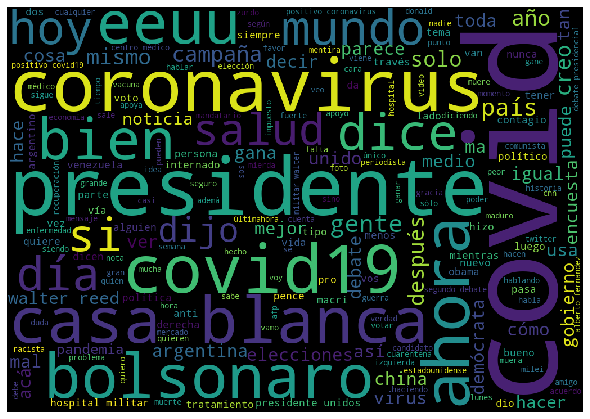

In [43]:
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud_a)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('a_wordcloud.png')
plt.show()


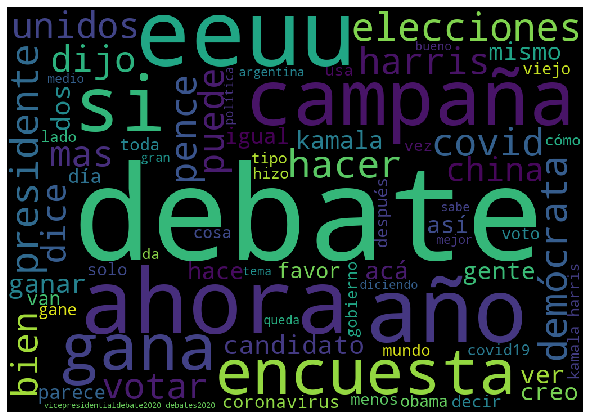

In [44]:
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud_b)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('b_wordcloud.png')
plt.show()


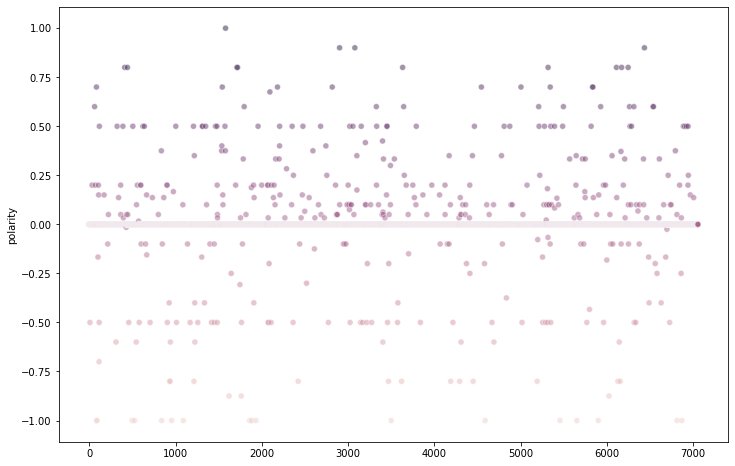

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.scatterplot(data=df_a, x=df_a.index, y="polarity", hue="polarity", legend=False, alpha=.5, ax=ax)
plt.savefig('a_polarity.png')

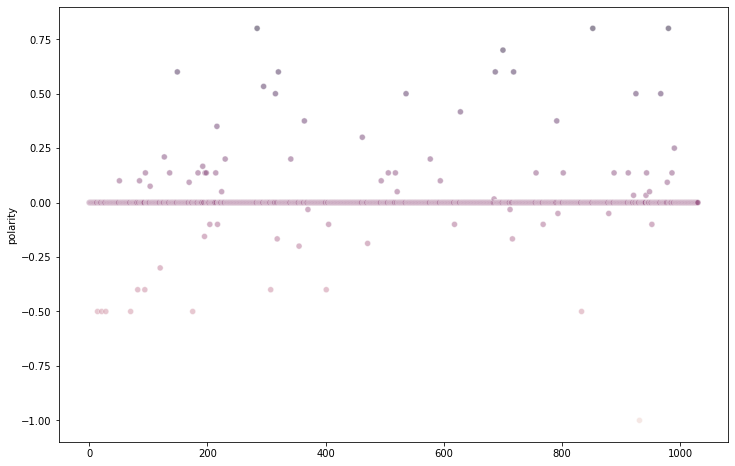

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.scatterplot(data=df_b, x=df_b.index, y="polarity", hue="polarity", legend=False, alpha=.5, ax=ax)
plt.savefig('b_polarity.png')